# Creating graphs for relationships between categories

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import json

from sklearn.manifold import TSNE

## Functions

In [2]:
def sel_one_way(relevant_df):
    """
    When sP(A|B) is significant, sP(B|A) is too.
    Select the largest effect of the two.
    """
    
    # If one way is statistically significant, the other one is as well.
    assert set(relevant_df['A'] + relevant_df['B']) == set(relevant_df['B'] + relevant_df['A'])

    # Select just the strongest of the sentiment pairs:
    one_way_df = relevant_df.loc[relevant_df['sP(A|B)'].abs().sort_values(ascending=False).index].copy()
    one_way_df = one_way_df.drop_duplicates(subset='pair_id', keep='first').sort_values('sP(A|B)')
    
    return one_way_df

## Load translations

In [3]:
# Load categories translation:
with open('../data/cleaned/translations_emo.json', 'r') as f:
    emo_translation   = json.load(f)
with open('../data/cleaned/translations_moral.json', 'r') as f:
    moral_translation = json.load(f)
translation = {**moral_translation, **emo_translation}         

## Analysis

In [4]:
# Load data:
stat_df = pd.read_csv('../data/processed/emo-emo_v1_statistics.csv')

# Create an ID for the sentiment pair:
stat_df['pair_id'] = stat_df['A'] + stat_df['B']
stat_df['pair_id'].where(stat_df['A'] < stat_df['B'], stat_df['B'] + stat_df['A'], inplace=True)

# Select the strongest of the directions:
oneway_df = sel_one_way(stat_df)
# Copy to the other direction:
otherway_df = oneway_df.copy()
otherway_df['A'] = oneway_df['B']
otherway_df['B'] = oneway_df['A']
# Join the two:
simm_df = pd.concat([oneway_df, otherway_df], ignore_index=True)

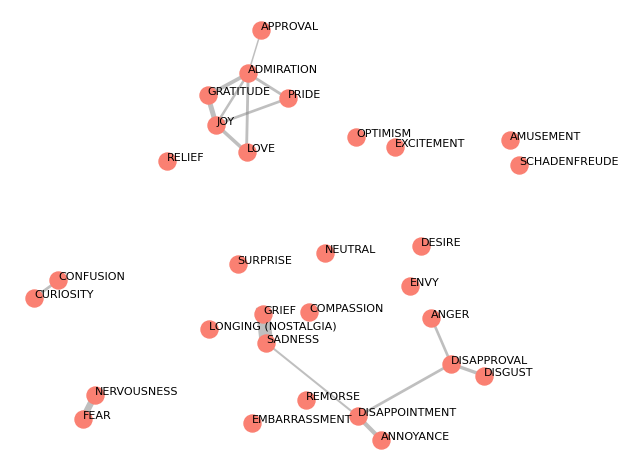

In [27]:
# Matriz de significância:
alpha = 0.02 / (15 * 29)
pvalue_df = stat_df.pivot(index='A', columns='B', values='s p-value')

# Matriz de pesos:
w_df = simm_df.pivot(index='A', columns='B', values='sP(A|B)')
min_w = w_df.min(axis=None)

# Significant connections:
significant_df = (pvalue_df.fillna(1) < alpha).astype(int)
# Categories that attract each other:
attract_df = ((w_df.fillna(-1) > 0) & (significant_df == 1)).astype(int)

# Only significant positive associations:
adj_df = (w_df.fillna(0) * attract_df).clip(lower=0)

# Distance matrix:
X = (w_df.max(axis=None) + 0.01 - w_df).fillna(0)

tsne = TSNE(metric='precomputed', init='random', perplexity=5, random_state=5)
plane = tsne.fit_transform(X)

cats = adj_df.columns
n_cats = len(cats)
for i in range(n_cats):
    for j in range(i + 1, n_cats):
        w = adj_df.iloc[i, j]
        if w > 0:
            pl.plot([plane[i][0], plane[j][0]], [plane[i][1], plane[j][1]], color='0.5', alpha=0.5, linewidth=w * 15)
            
pl.scatter(plane[:,0], plane[:,1], color='salmon', zorder=2, s=150)
for tup, txt in zip(plane, cats):
    pl.text(tup[0], tup[1], translation[txt], fontsize=8)

pl.axis('off')
pl.tight_layout()
#pl.savefig('plots/emo-emo_association-graph.png')